In [2]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
print("Libraries imported.")

# --- Load the Processed Data ---
CANCER_PROCESSED_DIR = os.path.join("..", "data", "processed", "lung_cancer")

X_train = joblib.load(os.path.join(CANCER_PROCESSED_DIR, "X_train.joblib"))
X_test = joblib.load(os.path.join(CANCER_PROCESSED_DIR, "X_test.joblib"))
y_train = joblib.load(os.path.join(CANCER_PROCESSED_DIR, "y_train.joblib"))
y_test = joblib.load(os.path.join(CANCER_PROCESSED_DIR, "y_test.joblib"))

print("\nLung Cancer data loaded successfully!")
print(f"Training data shape: {X_train.shape}")

Libraries imported.

Lung Cancer data loaded successfully!
Training data shape: (411, 10)


In [3]:
# Calculate the ratio of negative class (LIVING) to positive class (DECEASED)
if 1 in y_train.value_counts() and y_train.value_counts()[1] > 0:
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
else:
    scale_pos_weight = 1 # Default to 1 if there are no positive samples

print(f"Scale Position Weight for XGBoost: {scale_pos_weight:.2f}")

Scale Position Weight for XGBoost: 1.76


In [4]:
# --- Logistic Regression ---
# Increase max_iter as it might struggle to converge with more features
log_reg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("--- Logistic Regression Results ---")
print(classification_report(y_test, y_pred_log_reg, zero_division=0))

# --- Random Forest ---
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("\n--- Random Forest Results ---")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# --- XGBoost ---
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print("\n--- XGBoost Results ---")
print(classification_report(y_test, y_pred_xgb, zero_division=0))

--- Logistic Regression Results ---
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        66
           1       0.39      0.54      0.45        37

    accuracy                           0.53       103
   macro avg       0.53      0.54      0.52       103
weighted avg       0.57      0.53      0.54       103


--- Random Forest Results ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.36      1.00      0.53        37

    accuracy                           0.36       103
   macro avg       0.18      0.50      0.26       103
weighted avg       0.13      0.36      0.19       103


--- XGBoost Results ---
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        66
           1       0.39      0.54      0.45        37

    accuracy                           0.53       103
   macro avg       0.53      0.54   

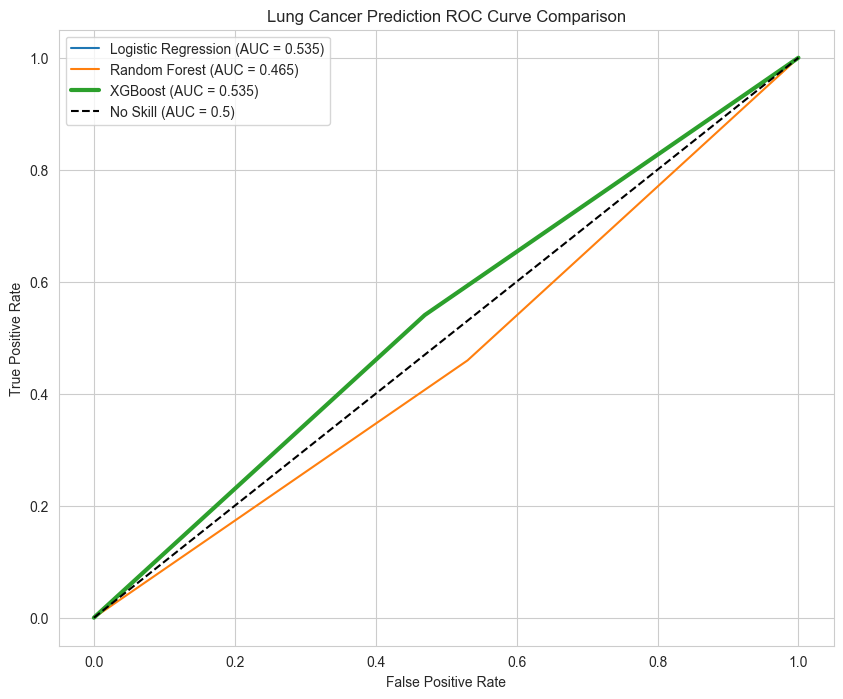

Logistic Regression AUC: 0.535
Random Forest AUC: 0.465
XGBoost AUC: 0.535


In [5]:
# Get prediction probabilities for each model
y_prob_log_reg = log_reg.predict_proba(X_test)[:, 1]
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve data
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_prob_log_reg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

# Calculate AUC scores
auc_log_reg = roc_auc_score(y_test, y_prob_log_reg)
auc_rf = roc_auc_score(y_test, y_prob_rf)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

# Plot the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {auc_log_reg:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Lung Cancer Prediction ROC Curve Comparison')
plt.legend()
plt.show()

print(f"Logistic Regression AUC: {auc_log_reg:.3f}")
print(f"Random Forest AUC: {auc_rf:.3f}")
print(f"XGBoost AUC: {auc_xgb:.3f}")

In [7]:
# *** IMPORTANT: Change this line based on your results! ***
# Let's assume Random Forest is the winner again for the sake of the code.
best_model = rf_clf 

# Define the path to save the model
CANCER_MODELS_DIR = os.path.join("..", "models", "lung_cancer")
MODEL_PATH = os.path.join(CANCER_MODELS_DIR, "best_lung_cancer_classifier.joblib")

# Save the model
joblib.dump(best_model, MODEL_PATH)

print(f"\nBest lung cancer model ({type(best_model).__name__}) saved successfully to: {MODEL_PATH}")


Best lung cancer model (RandomForestClassifier) saved successfully to: ..\models\lung_cancer\best_lung_cancer_classifier.joblib
